## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, TPABC, SMCABC, SMC2ABC, SNLABC, SNL2ABC
import distributions 
import scipy.stats as stats

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

In [2]:
from problems.ABC_problems import ABC_Problem

class Gauss_Problem(ABC_Problem): #problem from Fig.4A in PLoS CB Copula paper
    
    def __init__(self, N=100, n=100):
        
        self.N = N # number of posterior samples
        self.n = n # length of the data vector x = {x_1, ..., x_n}
        self.D = 5 # dimensionality of data samples
#         self.d = 5 # dims of sufficient statistics? d=2K? This argument is just not used anywhere... great
        self.prior_args = np.array([[0,1]]) # these are bounds on theta (on X in our case: [0,1])
        
        self.K = 1 # number of thetas
        self.stat = 'raw' # raw means that sufficient statistics is unknown (I guess). y_obs = data_obs
        
#         self.data_obs = self.y_obs #important that first dim=N & y_dim = product of these dims
        
    def get_true_theta(self):
        pass # does not matter, as the result goes into 'statistics', where theta is currently not used

    def sample_from_prior(self,size=1):
        return np.random.rand(size)
    
    def simulator(self, theta):
        rho = -0.1 + (0.999+0.1)*theta #problem from Fig.4A in PLoS CB Copula paper, linearly changing rho
        samples = np.zeros((theta.size,self.n,self.D))
        for i,r in enumerate(rho):
            samples[i] = np.random.multivariate_normal(np.zeros(self.D),np.ones((self.D,self.D))*r +\
                                                np.eye(self.D)*(1-r),size=self.n)
        return samples.reshape((-1,self.D)) # [number of theta samples (normally 1) x self.n] x self.D

    # B. correlation between latent
    def _ss_corr(self, Z):
        V = np.mat(Z).T * np.mat(Z) / Z.shape[0]
        (d,d) = V.shape
        upper_tri_elements = V[np.triu_indices(d, k=1)]
        stat = np.array(upper_tri_elements)
        return stat
    
    def statistics(self, data, theta=None):
        if self.stat == 'raw':
            # (correlation) as summary statistics (all margianls are N(0,1) here, don't matter)
            stat = self._ss_corr(data)
            return stat
        else:
            raise NotImplementedError('No ground truth statistics')

In [3]:
DIR = 'results/Gauss'

problem = Gauss_Problem()
theta = problem.sample_from_prior(size=100) # sample some thetas
problem.data_obs = problem.simulator(theta) # generate 'true' observations

In [4]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:0'
hyperparams.num_sim = 1000                        # number of simulations
hyperparams.L = 5                                # number of learning rounds
hyperparams.hidden_ratio = 0.1                   # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x), use CNN here
hyperparams.estimator = 'NWJ'                    # MI estimator; JSD or DC, see the paper
hyperparams.nde = 'MDN'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)


In [5]:
snl2_abc.run()


iteration  0
# of cpus =  4
[ABC] sub-process start![ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!

[sampling] finished sampling  10
[sampling] finished sampling  20
[sampling] finished sampling  30
[sampling] finished sampling  40

 > fitting encoder
summary statistic dim = 1 original dim = 10
architecture [10, 100, 100, 1]
validation size= 0.8
finished: t= 0 loss= 0.5862871408462524 loss val= 0.5824804306030273 time= 0.0644533634185791
finished: t= 50 loss= 0.38697391748428345 loss val= 0.3889622390270233 time= 0.06012606620788574
finished: t= 100 loss= 0.13830256462097168 loss val= 0.14646920561790466 time= 0.05761003494262695
finished: t= 150 loss= 0.02726912498474121 loss val= 0.03884536027908325 time= 0.060192108154296875
finished: t= 200 loss= 0.006212353706359863 loss val= 0.009167909622192383 time= 0.054904937744140625
finished: t= 250 loss= 0.0016643404960632324 loss val= 0.0025238394737243652 time= 0.05496382713317871
finished: t= 300 loss= -0.002

finished: t= 1650 loss= -1.3668513298034668 loss val= -1.3363839387893677 time= 0.10549592971801758
finished: t= 1700 loss= -1.3824882507324219 loss val= -1.3583734035491943 time= 0.10770988464355469
finished: t= 1750 loss= -1.3706225156784058 loss val= -1.3514580726623535 time= 0.10589408874511719
finished: t= 1800 loss= -1.3881570100784302 loss val= -1.3427209854125977 time= 0.10665249824523926
finished: t= 1850 loss= -1.3822171688079834 loss val= -1.3541969060897827 time= 0.10704851150512695
finished: t= 1900 loss= -1.3913023471832275 loss val= -1.3572800159454346 time= 0.10420584678649902
best val loss= -1.384033441543579

 > fitting nde
all_stats.size() torch.Size([400, 1])
finished: t= 0 loss= 25.443403244018555 loss val= 25.521623611450195
finished: t= 250 loss= 3.996159315109253 loss val= 4.017160892486572
finished: t= 500 loss= 3.2251229286193848 loss val= 3.2285313606262207
finished: t= 750 loss= 1.851866602897644 loss val= 1.8917019367218018
best val loss= 1.8880970478057861

finished: t= 550 loss= -1.2558083534240723 loss val= -1.273091435432434 time= 0.07226800918579102
finished: t= 600 loss= -1.3558943271636963 loss val= -1.2791733741760254 time= 0.0718849500020345
finished: t= 650 loss= -1.355332374572754 loss val= -1.2851152420043945 time= 0.07134326299031575
finished: t= 700 loss= -1.3218410015106201 loss val= -1.2853959798812866 time= 0.07122548421223958
finished: t= 750 loss= -1.3398327827453613 loss val= -1.294788122177124 time= 0.0873250166575114
finished: t= 800 loss= -1.2976503372192383 loss val= -1.2920335531234741 time= 0.06926528612772624
finished: t= 850 loss= -1.3911255598068237 loss val= -1.3067947626113892 time= 0.07001868883768718
finished: t= 900 loss= -1.3813962936401367 loss val= -1.3068760633468628 time= 0.07134747505187988
finished: t= 950 loss= -1.3453569412231445 loss val= -1.3141629695892334 time= 0.06995320320129395
finished: t= 1000 loss= -1.4685027599334717 loss val= -1.310555100440979 time= 0.06998761494954427
finished: t= 10

(array([109.,  95., 116., 104.,  96.,  93.,  79., 116.,  89., 103.]),
 array([1.62951717e-06, 9.98927073e-02, 1.99783785e-01, 2.99674863e-01,
        3.99565940e-01, 4.99457018e-01, 5.99348096e-01, 6.99239174e-01,
        7.99130251e-01, 8.99021329e-01, 9.98912407e-01]),
 <a list of 10 Patch objects>)

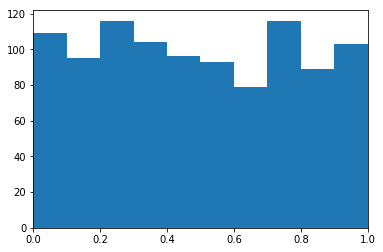

In [6]:
# let us check that the prior did not collapse 
theta = np.empty(1000)
for i in range(len(theta)): 
    theta[i] = snl2_abc.prior()
plt.xlim([0,1])
plt.hist(theta)

In [ ]:
# calculate MI using all generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[0:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[0:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100) # n here is the number of shuffles

In [8]:
# calculate MI using the last generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[snl2_abc.l:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[snl2_abc.l:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100) # n here is the number of shuffles

torch.Size([200, 1])


tensor(1.4432, grad_fn=<SubBackward0>)

In [9]:
# see Fig.4A in PLoS CB paper for correct answers. Should be roughly 1 bit for 10 dims (D), 0.7 bits for 5 dims
# DV looks alright! 
# DC just always returns 0.9something, whatever the data

NameError: name 'PCA' is not defined

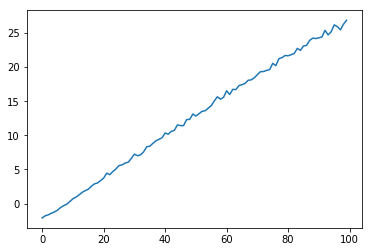

In [10]:
# visualize latents s(x)
nbins=100
stats2plot = []
data2plot = []
summary2plot = []
for i in range(nbins):
    theta = np.repeat(i/(nbins-1),100) #100 simulations
    generated = snl2_abc.problem.simulator(theta)
    get_stat = snl2_abc.convert_stat(snl2_abc.problem.statistics(generated))
    stats2plot.append(get_stat)
    data2plot.append(generated.mean(0))
    summary2plot.append(snl2_abc.problem.statistics(generated))
    
plt.plot(np.array(stats2plot).squeeze())
# np.array(stats2plot).shape
# from sklearn.manifold import TSNE, SpectralEmbedding
# from sklearn.decomposition import PCA
# latent_PCA = PCA(n_components=2).fit_transform(np.array(stats2plot).reshape(-1,1))
# latent_TSNE = TSNE(n_components=2).fit_transform(np.array(stats2plot).squeeze())
# latent_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(stats2plot).squeeze())


summary_PCA = PCA(n_components=2).fit_transform(np.array(summary2plot).squeeze())
summary_TSNE = TSNE(n_components=2).fit_transform(np.array(summary2plot).squeeze())
summary_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(summary2plot).squeeze())


data_PCA = PCA(n_components=2).fit_transform(np.array(data2plot).squeeze())
data_TSNE = TSNE(n_components=2).fit_transform(np.array(data2plot).squeeze())
data_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(data2plot).squeeze())




In [ ]:
import matplotlib.cm as cm
fig = plt.figure(figsize=(7,6))

# fig.add_axes([0,0,1,1])


ax = [fig.add_axes([0.05,0,0.2,0.25]),
      fig.add_axes([0.3,0,0.2,0.25]),
      fig.add_axes([0.55,0,0.2,0.25]),
     fig.add_axes([0.05,0.35,0.2,0.25]),
     fig.add_axes([0.3,0.35,0.2,0.25]),
      fig.add_axes([0.55,0.35,0.2,0.25]),
     fig.add_axes([0.05,0.7,0.2,0.25]),
     fig.add_axes([0.3,0.7,0.2,0.25]),
      fig.add_axes([0.55,0.7,0.2,0.25]),
     fig.add_axes([0.85,0.3,0.1,0.4]),]

ax[0].scatter(*data_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[1].scatter(*data_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[2].scatter(*data_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

ax[3].scatter(*summary_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[4].scatter(*summary_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[5].scatter(*summary_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

# ax[6].scatter(*latent_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
# ax[7].scatter(*latent_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
# ax[8].scatter(*latent_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

for a in [ax[0],ax[3],ax[6]]:
    a.set_xlabel('PCA 1')
    a.set_ylabel('PCA 2')
    
for a in [ax[1],ax[4],ax[7]]:
    a.set_xlabel('t-SNE 1')
    a.set_ylabel('t-SNE 2')
    
for a in [ax[2],ax[5],ax[8]]:
    a.set_xlabel('L-eigen 1')
    a.set_ylabel('L-eigen 2')
    
for a in ax[:-1]:
    a.set_xticks([])
    a.set_yticks([])
    
ax[9].imshow(np.repeat(np.linspace(0,1,160).reshape(1,-1),10,axis=0).T,cmap=cm.rainbow)
ax[9].set_ylabel("Position in VR, cm")

fig.text(0.27,0.96,'Sufficient statistics',fontsize=14)
fig.text(0.27,0.61,'Summary statistics',fontsize=14)
fig.text(0.32,0.26,'Binned data',fontsize=14)

# help(plt.imshow)
# plt.scatter(*X_embedded[int(nbins*20/160):int(nbins*60/160)].T,marker='x',color='k') #late part of the corridor marked